# Titanic Dataset

## Lib Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Remove warnings from workbook.

In [22]:
import warnings

warnings.simplefilter('ignore')

In [23]:
RANDOM_STATE = 123

**Custom Helper Methods**

In [24]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

def replace_missing_age_values(df):
    mean_age = df['Age'].mean()
    df['Age'] = df['Age'].fillna(mean_age)

def replace_missing_fare_values(df):
    mean_fare = df['Fare'].mean()
    df['Fare'] = df['Fare'].fillna(mean_fare)

def create_titles_column(df):
    passenger_names = df['Name'].str.split(',')
    df['Title'] = [passenger_name[1].lstrip().split(' ')[0][:-1] for passenger_name in passenger_names]
    df.drop('Name', inplace=True, axis=1)

def create_family_size_column(df):
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df.drop(['SibSp', 'Parch'], inplace=True, axis=1)
    
def label_and_scale_columns(df):
    #TODO: move to ColumnTransformer class
    min_max_scaler = MinMaxScaler()
    NUMERICAL_COLUMNS = ['Age', 'Fare']
    df[NUMERICAL_COLUMNS] = min_max_scaler.fit_transform(df[NUMERICAL_COLUMNS])
    
    label_encoder = LabelEncoder()
    df['Sex'] = label_encoder.fit_transform(df['Sex'])
    df['Embarked'] = label_encoder.fit_transform(df['Embarked'])
    df['Title'] = label_encoder.fit_transform(df['Title'])

def drop_unnecessary_columns(df):
    COLUMNS_TO_DROP = ['PassengerId', 'Ticket', 'Cabin']
    df.drop(COLUMNS_TO_DROP, inplace=True, axis=1)

def preprocess_dataset(df):
    """_summary_

    Args:
        df (_type_): _description_
    """
    replace_missing_age_values(df)
    replace_missing_fare_values(df)
    create_titles_column(df)
    create_family_size_column(df)
    label_and_scale_columns(df)
    drop_unnecessary_columns(df)

## 1. Dataset Loading

In [7]:
train_df = pd.read_csv('train.csv')

In [8]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### 1.1 Missing Dataset Analysis

In [10]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Three columns are missing values within the training dataset:

* Age: 177 missing values which is significant as age was likely a significant factor in the survival on the Titanic.
* Cabin: missing substantial values but not likely significant so can also be removed.
* Embarked: only missing two entries so can probably just be removed.

In [11]:
empty_age_mask = (train_df['Age'].isna())

In [12]:
empty_age_df = train_df[empty_age_mask]
empty_age_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


### 1.2 Title Extraction

It may be worth investigating whether there titles in the names can be used to help fill in missing age values.

Start by creating a list of components of the name string split by ','.

In [13]:
passenger_names = train_df['Name'].str.split(',')
passenger_names

0                             [Braund,  Mr. Owen Harris]
1      [Cumings,  Mrs. John Bradley (Florence Briggs ...
2                              [Heikkinen,  Miss. Laina]
3        [Futrelle,  Mrs. Jacques Heath (Lily May Peel)]
4                            [Allen,  Mr. William Henry]
                             ...                        
886                             [Montvila,  Rev. Juozas]
887                      [Graham,  Miss. Margaret Edith]
888          [Johnston,  Miss. Catherine Helen "Carrie"]
889                             [Behr,  Mr. Karl Howell]
890                               [Dooley,  Mr. Patrick]
Name: Name, Length: 891, dtype: object

Next create a list of titles by splitting the second list value by ' ' and taking the first entry.

In [14]:
titles = [passenger_name[1].lstrip().split(' ')[0][:-1] for passenger_name in passenger_names]

In [15]:
print(f"num titles {len(titles)}")

num titles 891


Converting to a set.

In [16]:
title_set = set(titles)
print(f"num unique titles: {len(title_set)}")

num unique titles: 17


### 1.3 Missing Age Analysis

Now I'm going to investigate the relationship between age and other variables to determine if there is a more exact way of filling in missing age data.

In [26]:
complete_df = train_df[~empty_age_mask]
complete_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [27]:
preprocess_dataset(complete_df)
complete_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0,3,1,0.271174,0.014151,2,11,1
1,1,1,0,0.472229,0.139136,0,12,1
2,1,3,0,0.321438,0.015469,2,8,0
3,1,1,0,0.434531,0.103644,2,12,1
4,0,3,1,0.434531,0.015713,2,11,0


<Axes: >

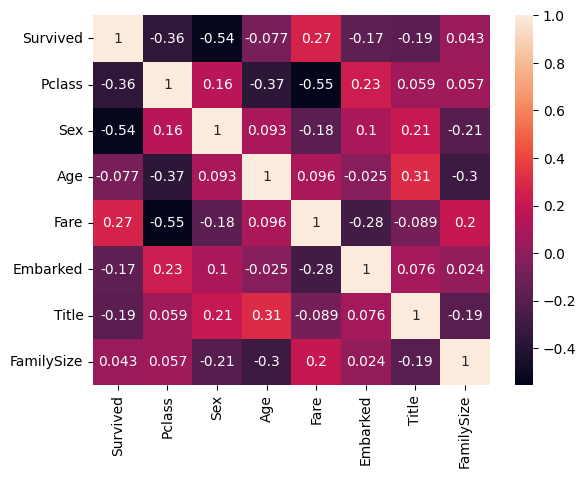

In [28]:
sns.heatmap(complete_df.corr(), annot=True)

## 3. Feature Engineering and Preprocessing

Based on discussions and research, the below features will be engineered:

* FamilySize: this represents the combination of SibSp and Parch column.
* Title: will used a refactored version of the code from 2.3 to convert names to Titles.

The below columns with be LabelEncoded:

* Title
* Sex
* Embarked

Furthermore the below columns will be dropped:

* 'PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Cabin'

In [47]:
preprocess_dataset(train_df)
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0,3,1,0.271174,0.014151,2,11,1
1,1,1,0,0.472229,0.139136,0,12,1
2,1,3,0,0.321438,0.015469,2,8,0
3,1,1,0,0.434531,0.103644,2,12,1
4,0,3,1,0.434531,0.015713,2,11,0


In [48]:
train_df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
Title         0
FamilySize    0
dtype: int64

In [49]:
len(train_df)

891

## 4. X and y split

In [50]:
Y_COLUMN = 'Survived'

In [51]:
y = train_df[Y_COLUMN]
X = train_df.drop(Y_COLUMN, axis=1)

In [52]:
X.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,3,1,0.271174,0.014151,2,11,1
1,1,0,0.472229,0.139136,0,12,1
2,3,0,0.321438,0.015469,2,8,0
3,1,0,0.434531,0.103644,2,12,1
4,3,1,0.434531,0.015713,2,11,0


In [53]:
y.value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

## 5. Train Test Split

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

## 6. Model Training

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
lr_model = LogisticRegression()

In [58]:
lr_model.fit(X_train, y_train)

LogisticRegression()

## 7. Model Evaluation

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [60]:
def get_classification_metrics(y_true, y_pred, name):
    return {
        'name': name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

In [61]:
y_pred = lr_model.predict(X_test)

In [62]:
get_classification_metrics(y_test, y_pred, 'Logistic Regression')

{'name': 'Logistic Regression',
 'accuracy': 0.7985074626865671,
 'precision': np.float64(0.7391304347826086),
 'recall': np.float64(0.6938775510204082),
 'f1_score': np.float64(0.7157894736842105)}

## 8. Kaggle Prediction Generation and Submissions

The next section reads the test dataset, applies the same preprocessing as for the training set, runs predictions and reformats csv file so it can be submitted to Kaggle.

In [94]:
test_df = pd.read_csv('test.csv')

In [95]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [96]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [97]:
X_val = test_df.copy()
preprocess_dataset(X_val)

In [98]:
X_val.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,3,1,0.452723,0.015282,1,5,0
1,3,0,0.617566,0.013663,2,6,1
2,2,1,0.815377,0.018909,1,5,0
3,3,1,0.353818,0.016908,2,5,0
4,3,0,0.287881,0.023984,2,6,2


In [99]:
y_val = lr_model.predict(X_val)

In [100]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_val})
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [101]:
submission.to_csv('submission.csv', index=False)